In [216]:
#Declaring imports
import csv
import os
import pandas as pd
import xgboost as xgb

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xgd



In [217]:
DEBUGGING = False

In [218]:
#Files
train_data_path = '../input/train.csv'
test_data_path = '../input/test.csv'

In [219]:
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)


In [220]:
if DEBUGGING:
    partition = 0.9 * train_df.shape[0]
    test_df = train_df.loc[partition:,]
    train_df = train_df.loc[:partition,]
    

# Exploratory Data Analysis

In [221]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [222]:
#putting each col into a bucket
discrete = []
continuous = []
for col in train_df.columns:
    length = len(train_df[col].unique())
    if length <= 25 :
        discrete.append(col)
    else:
        continuous.append(col)
        

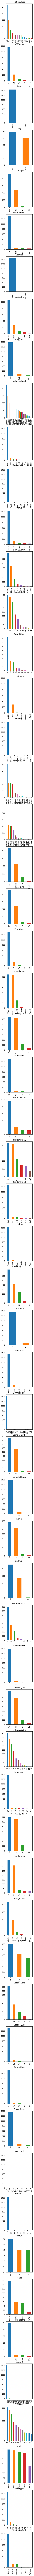

In [223]:
#Seeing the distribution of discrete data

fig, axes = plt.subplots(nrows=len(discrete), ncols=1, figsize=(3,5*len(discrete)))
for i, col_name in enumerate(discrete):
    train_df[col_name].value_counts().plot(kind='bar', ax=axes[i], title = col_name)


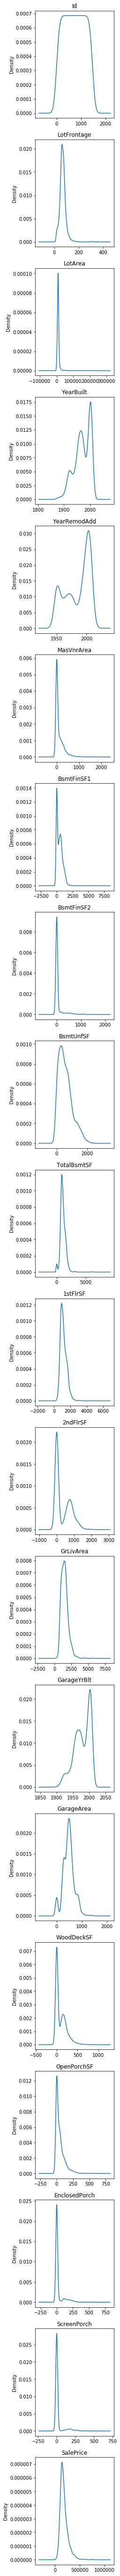

In [224]:
#Distributions of continuous data
fig, axes = plt.subplots(nrows=len(continuous), ncols=1, figsize=(3,5*len(continuous)))
for i, col_name in enumerate(continuous):
    try:
        train_df[col_name].plot(kind='density', ax=axes[i], title = col_name)
    except:
        print("failed: " + col_name)


In [225]:
#Finding number of null values
def count_nulls(train_df, test_df):
    results = {}
    vals = {}
    for key in train_df.keys():
        count = train_df[key].isnull().sum()
        if count > 0:
            vals[key] = count
    results['train'] = vals

    vals = {}
    for key in test_df.keys():
        count = test_df[key].isnull().sum()
        if count > 0:
            vals[key] = count
    results['test'] = vals
    
    return pd.DataFrame.from_dict(results, dtype=int)

count_nulls(train_df, test_df)

,train,test
Alley,1369.0,1352.0
BsmtCond,37.0,45.0
BsmtExposure,38.0,44.0
BsmtFinSF1,NaN,1.0
BsmtFinSF2,NaN,1.0
BsmtFinType1,37.0,42.0
BsmtFinType2,38.0,42.0
BsmtFullBath,NaN,2.0
BsmtHalfBath,NaN,2.0
BsmtQual,37.0,44.0


In [226]:
print(train_df.shape)
print(test_df.shape)

(1460, 81)
(1459, 80)


In [227]:
def replace_na(cols, val):
    for df in [train_df, test_df]:
        if type(cols) == list:
            for col in cols:
                df.loc[:, col] = df.loc[:, col].fillna(val)
        else:
            df.loc[:, cols] = df.loc[:, cols].fillna(val)

#Some NaNs indicate the absence of a feature (Indicated from data sheet)
replace_na(["Alley", "MiscFeature", "PoolQC", "Fence", "FireplaceQu",
                     "GarageType", "GarageFinish", "GarageQual", "GarageCond",
                     'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                     "MasVnrType", 'MSSubClass'], "None")

#Some NaNs indicate that there are 0 values
replace_na(['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
                      'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', "MasVnrArea"], 0)


In [228]:
train_df["LotFrontage"] = train_df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
test_df["LotFrontage"] = train_df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [229]:
train_df['MSZoning'] = train_df['MSZoning'].fillna(train_df['MSZoning'].mode()[0])
test_df['MSZoning'] = test_df['MSZoning'].fillna(test_df['MSZoning'].mode()[0])

In [230]:
train_df.drop(['Utilities'], inplace = True, axis = 1)
test_df.drop(['Utilities'], inplace = True, axis = 1)

In [231]:
replace_na("Functional", "Typ")

In [232]:
def replace_na_with_most_frequent(col):

    most = train_df.append(test_df)[col].mode()[0]
    replace_na(col, most)

In [233]:
replace_na_with_most_frequent("KitchenQual")
replace_na_with_most_frequent("Exterior1st")
replace_na_with_most_frequent("Exterior2nd")
replace_na_with_most_frequent("SaleType")
replace_na_with_most_frequent("SaleType")
replace_na_with_most_frequent("Electrical")


/anaconda/envs/tensorflow/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


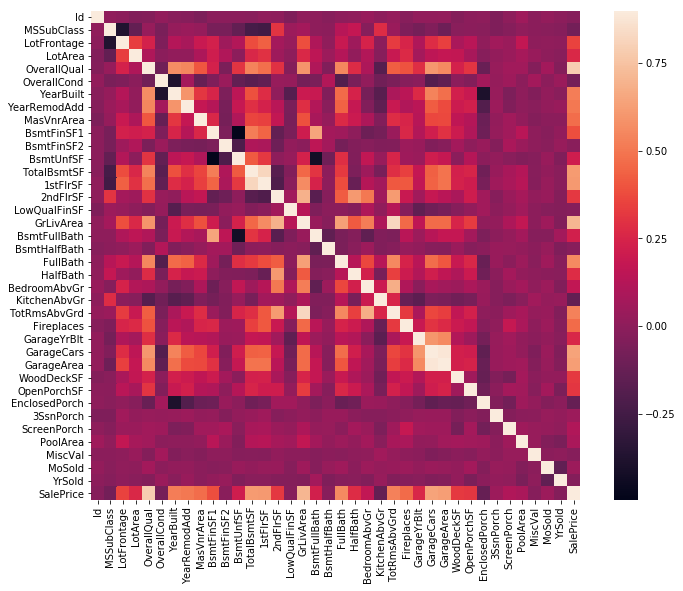

In [234]:
corrmat = train_df.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

#Things that I should consider doing:
1) Remove outliers from data
2) Start applying regression techniques

In [235]:
all_data = train_df.append(test_df)
print(train_df.shape)
print(test_df.shape)
print(all_data.shape)

(1460, 80)
(1459, 79)
(2919, 80)


/anaconda/envs/tensorflow/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [236]:
#Replace categories that are really categorical rather than 
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

0          1stFlrSF
1          2ndFlrSF
2         3SsnPorch
3             Alley
4      BedroomAbvGr
5          BldgType
6          BsmtCond
7      BsmtExposure
8        BsmtFinSF1
9        BsmtFinSF2
10     BsmtFinType1
11     BsmtFinType2
12     BsmtFullBath
13     BsmtHalfBath
14         BsmtQual
15        BsmtUnfSF
16       CentralAir
17       Condition1
18       Condition2
19       Electrical
20    EnclosedPorch
21        ExterCond
22        ExterQual
23      Exterior1st
24      Exterior2nd
25            Fence
26      FireplaceQu
27       Fireplaces
28       Foundation
29         FullBath
30       Functional
31       GarageArea
32       GarageCars
33       GarageCond
34     GarageFinish
35       GarageQual
36       GarageType
37      GarageYrBlt
38        GrLivArea
39         HalfBath
40          Heating
41        HeatingQC
42       HouseStyle
43               Id
44     KitchenAbvGr
45      KitchenQual
46      LandContour
47        LandSlope
48          LotArea
49        LotConfig


In [238]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2919, 80)


In [241]:
print(test_df.shape)
print(all_data[1460:].shape)


(1459, 79)
(1459, 80)


0       1461
1       1462
2       1463
3       1464
4       1465
5       1466
6       1467
7       1468
8       1469
9       1470
10      1471
11      1472
12      1473
13      1474
14      1475
15      1476
16      1477
17      1478
18      1479
19      1480
20      1481
21      1482
22      1483
23      1484
24      1485
25      1486
26      1487
27      1488
28      1489
29      1490
        ... 
1429    2890
1430    2891
1431    2892
1432    2893
1433    2894
1434    2895
1435    2896
1436    2897
1437    2898
1438    2899
1439    2900
1440    2901
1441    2902
1442    2903
1443    2904
1444    2905
1445    2906
1446    2907
1447    2908
1448    2909
1449    2910
1450    2911
1451    2912
1452    2913
1453    2914
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, Length: 1459, dtype: int64

In [187]:
all_data = pd.get_dummies(all_data)

In [188]:
all_data.drop('Id', axis=1,inplace=True)
test_ID = test_df['Id']

In [189]:
train_df = all_data[:1460]
test_df = all_data[1460:]
test_df.drop('SalePrice', axis=1, inplace=True)

/anaconda/envs/tensorflow/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [190]:
print(pd.Series(all_data.columns).to_string())

0                   1stFlrSF
1                   2ndFlrSF
2                  3SsnPorch
3                      Alley
4               BedroomAbvGr
5                   BsmtCond
6               BsmtExposure
7                 BsmtFinSF1
8                 BsmtFinSF2
9               BsmtFinType1
10              BsmtFinType2
11              BsmtFullBath
12              BsmtHalfBath
13                  BsmtQual
14                 BsmtUnfSF
15                CentralAir
16             EnclosedPorch
17                 ExterCond
18                 ExterQual
19                     Fence
20               FireplaceQu
21                Fireplaces
22                  FullBath
23                Functional
24                GarageArea
25                GarageCars
26                GarageCond
27              GarageFinish
28                GarageQual
29               GarageYrBlt
30                 GrLivArea
31                  HalfBath
32                 HeatingQC
33              KitchenAbvGr
34            

In [191]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb


/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda/envs/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 12.02 and sigma = 0.40



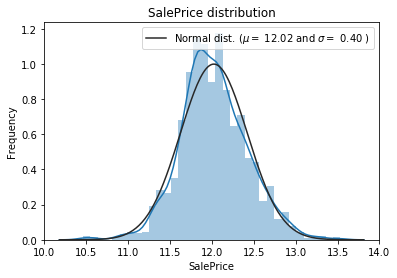

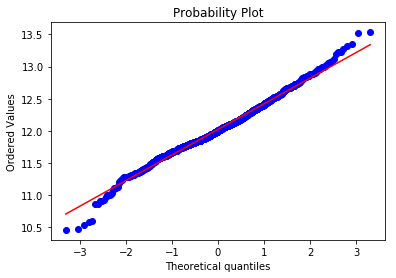

In [192]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

#Check the new distribution 
sns.distplot(train_df['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

In [193]:
x_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df.SalePrice.values

In [194]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train.values)
    rmse= np.sqrt(-cross_val_score(model, x_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [195]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
ridge = make_pipeline(RobustScaler(), Ridge(alpha=10))

In [196]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1373 (0.0300)



In [197]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1373 (0.0298)



In [198]:
score = rmsle_cv(ridge)
print("Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Ridge score: 0.1403 (0.0253)



#TODO: Refine alpha score
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_lasso = (rmsle())

In [199]:
KRR =  KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.8618 (0.2790)



/anaconda/envs/tensorflow/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.685010491654886e-19 / 1.1102230246251565e-16
  RuntimeWarning)
/anaconda/envs/tensorflow/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.8418906422730667e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/anaconda/envs/tensorflow/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.510323851984594e-19 / 1.1102230246251565e-16
  RuntimeWarning)
/anaconda/envs/tensorflow/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-c

In [200]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Gradient Boosting score: 0.1248 (0.0120)



In [201]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1225 (0.0092)



In [202]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1234 (0.0094)



In [203]:
#Averaging

In [204]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  

In [205]:
averaged_models = AveragingModels(models = (ENet, GBoost,lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


 Averaged base models score: 0.1275 (0.0227)



In [206]:
#Stacking Averaging

In [207]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [208]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1251 (0.0159)


In [209]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [210]:
stacked_averaged_models.fit(x_train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(x_train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test_df.values))
print(rmsle(y_train, stacked_train_pred))

0.06894964936293206


In [211]:
model_xgb.fit(x_train.values, y_train)
xgb_train_pred = model_xgb.predict(x_train.values)
xgb_pred = np.expm1(model_xgb.predict(test_df.values))
print(rmsle(y_train, xgb_train_pred))

0.08201271932838491


In [212]:
model_lgb.fit(x_train.values, y_train)
lgb_train_pred = model_lgb.predict(x_train.values)
lgb_pred = np.expm1(model_lgb.predict(test_df.values))
print(rmsle(y_train, lgb_train_pred))

0.07512635629669749


In [248]:
ensemble_train = 0.7 * stacked_train_pred + 0.15 * xgb_train_pred + 0.15 * lgb_train_pred

In [249]:
rmsle(ensemble_train, y_train)

0.06896313003402453

In [252]:

ensemble= 0.7 * stacked_pred + 0.15 * xgb_pred + 0.15 * lgb_pred



In [253]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)

(1459,)